# Capstone 1: Exercise 10.6.1: Part I: v4

# Regression on Ames Housing Data

## Game plan

I'm looking to predict the prices of residential sales in my Ames Housing Data set.  I've already cleaned the data and explored the data.  

Now, I'm looking to model the data.  

My game plan is to:

* Set up
* Load data
* Build any oft-used functions
* Define modeling approach
* Select features
* Prep data for modeling
* Split data
* Model by tuning, scoring off training and scoring off test

In addition, I'd like to:

* Run some additional models
* Compare scores across models

## History

* v1: Wrote baseline notebook for data prep, linear, ridge and lasso
* v2: Moved ridge and lasso off to appendix as not needed; evaluated overfitting of linear; evaluated overfitting across random picks of 75/25 split; examined normalized v. non-normalized linear; interpreted coefficients; interpreted prediction interval.
* v3:  Added prediction interval off residuals; picked up results.
* v4:  Exported more data for 10.6.1.2 notebook.  Cleaned up for final report.

## Set up

In [1]:
# Import basic libraries, set some defaults

import numpy as np
from numpy.random import seed
from numpy.random import randint

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')

import seaborn as sns

from scipy.stats import norm

In [2]:
# Import scikit learn libraries

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

## Load data

In [3]:
# Load the dataframe from prior cleaning work
df = pd.read_pickle("../sb_cap1_data/df_cln_v3.pickle")

## Define common functions

In [4]:
# Define a function to calc MAPE
# This isn't part of sklearn

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

Takeaway:
    
* Boy, I felt like I was cutting and pasting the same block of code with minor tweaks to variable names
* Clearly, theres an opportunity to think in terms of fucntions

## Define modeling approach

Here's how I'm looking at the data science problem:

* It's a supervised learning problem as I've got dependent variable (sale price) for each observation.
* It's a regression problem as:
    * I'm doing prediction.  Of a continuous variable.  Mostly using non-categorical predictors
    * I care about interpretability
    * Plus, I'm happy with establishing a baseline against which I can compare other models

Here's my approach to the regression problem:

* I'll use linear regression
    * univariate (as I have only one dependent variable)
    * multiple regression (as I have many independent variables)
* If I've got overfitting, I'll try to compensate with ridge and lasso regression.
* I will measure performance with:
    * r-squared
    * RMSE
    * MAPE

## Identify features of interest

I updated the work in my stats notebook to select key features.

For non-categorical features, I:

* Looked at individual feature's correlation with my target (i.e., persons r) as well as the respective p-values
* Set a floor for r-squared at 30% and statistical significance
* Looked at cross correlation between features
* Set a ceiling for feature cross correlation at 50%
* Got a list of 10 non-categorical variables

For categorical features, I:

* Looked at individual feature's correlation with my target (i.e., r-squared from a one-way ANOVA) as well as respective p-values
* Set a floor for r-squared at 30% and statistical significance
* Got a final list of 2 categorical variables

This gave me a total of 12 features.

In [5]:
# Load the lists from prior cleaning work

series_x_nocat = pd.read_pickle("../sb_cap1_data/list_targets_nocat.pickle")
series_x_cat = pd.read_pickle("../sb_cap1_data/list_targets_cat.pickle")

In [6]:
# Convert to lists

target_x_noncat_list = series_x_nocat.to_list()
target_x_cat_list = series_x_cat.to_list()
target_x_list = target_x_noncat_list + target_x_cat_list

# # Check
# print('My prior stats work gave me {} top-mind features.'.format(len(target_x_list)))
# print('')
# print('They are:')
# print('')
# print(target_x_list)

## Prepare data for ML

### Confirm that there are no nulls the dataframe

In [7]:
# # Chech
# df.isnull().sum().sum()

### Drop outliers from baseline dataframe

In [8]:
# List the 8 outliers (1.5 IRQ above 75%ile) from my prior exploratory analysis
outliers = [441, 692, 770, 804, 899, 1047, 1170, 1183]

# Drop the outliers
# Turn the ID (which are not zero based) into 0-based locations
for index in outliers:
    df.drop(index - 1, inplace=True)
    
# # Check:  How big is the data frame after the drop
# print('After dropping {} outliers from a data frame with 1460 rows, I have {} rows'.format(len(outliers), len(df)))

### Create dataframe of target variable - sale price

In [9]:
# Make new data frame with my one target
df_y = df[['SalePrice']].copy()

# # Check
# print(df_y.shape)

### Normalize target variable via log transformation

In [10]:
# Calc log of sales price
df_y['SalePriceLog'] = np.log(df_y['SalePrice'])

# # Check
# print(df_y.head(3))

# Drop SalePrice
df_y.drop(['SalePrice'], axis=1, inplace=True)

# # Check
# print(df_y.head(3))

### Create data frame of predictors of interest

In [11]:
# Copy a dataframe of only these columns
df_x = df[target_x_list].copy()
print(df_x.shape)

(1452, 12)


### Convert categorical predictors via one hot encoding


In [12]:
# # Check:  Observe how many columns in my dataframe
# print('Initially, there are {} columns'.format(len(df_x.columns)))
# print()
# print('Of the two categoricals,')
# print('One has {} unique values, and'.format(len(df_x['Neighborhood'].unique())))
# print('Other has {} unique values.'.format(len(df_x['GarageFinish'].unique())))

In [13]:
# One hot encode the categoricals
df_onehot_neig = pd.get_dummies(df_x['Neighborhood'])
df_onehot_garfin = pd.get_dummies(df_x['GarageFinish'])

# Concat the now-encoded categoricals back into the dataframe
df_x = pd.concat([df_x, df_onehot_neig, df_onehot_garfin], axis=1)

# Drop the orignal columns
df_x.drop(['Neighborhood', 'GarageFinish'], axis=1, inplace=True)

In [14]:
# List the values in Neighborhood
neig_list = df_onehot_neig.columns.to_list()
neig_list

['Blmngtn',
 'Blueste',
 'BrDale',
 'BrkSide',
 'ClearCr',
 'CollgCr',
 'Crawfor',
 'Edwards',
 'Gilbert',
 'IDOTRR',
 'MeadowV',
 'Mitchel',
 'NAmes',
 'NPkVill',
 'NWAmes',
 'NoRidge',
 'NridgHt',
 'OldTown',
 'SWISU',
 'Sawyer',
 'SawyerW',
 'Somerst',
 'StoneBr',
 'Timber',
 'Veenker']

In [15]:
# Drop one factor from Neighborhood
df_x.drop(['Veenker'], axis=1, inplace=True)

In [16]:
# List the values from GarageFinish
garfin_list = df_onehot_garfin.columns.to_list()
garfin_list

['Fin', 'No', 'RFn', 'Unf']

In [17]:
# Drop one factor from GarageFinish
df_x.drop(['Unf'], axis=1, inplace=True)

Question:

* I've got to drop one factor from each of my categoricals, right?
* And I interpret the results as moving from the dropped value up to the enumerated value, right?

In [18]:
# # Check:  Number of columns after
# print('After, there are {} columns'.format(len(df_x.columns)))
# print('MP by hand check:  12 + 25 + 4 - 2 (aka, original columns) - 2 (aka, one factor from each) = 37, yes')

### Save data for modeling

In [19]:
# Save as a picked dataframe
df_x.to_pickle('data/df_X_prepped.pickle')

In [20]:
# Save as a picked dataframe
df_y.to_pickle('data/df_y_prepped.pickle')

### Split data into train and test sets

In [21]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.25, random_state=42)

In [22]:
# # Check
# print('The size of the X training set is {}'.format(len(X_train)))
# print('The size of the X test set is {}'.format(len(X_test)))
# print()
# print('The size of the y training set is {}'.format(len(y_train)))
# print('The size of the y test set is {}'.format(len(y_test)))

In [23]:
y_test

,SalePriceLog
Id,
1042,12.061047
1131,11.813030
1003,12.354493
1325,11.898188
531,12.072541
...,...
516,12.906347
725,12.676076
846,12.049419


## Model with linear regression

### Tune model

In [24]:
# Instantiate a tuning model
lin_tune = LinearRegression()

# Set up the grid
parameters = {'normalize':[True,False],
              'fit_intercept':[True,False],
              'copy_X':[True,False]}

# Instantiate the gridsearch
lin_cv = GridSearchCV(lin_tune, parameters, cv=5)

# Fit the gridsearch to the test data
lin_cv.fit(X_train, y_train)

# Print results
print('The best parameters are {}'.format(lin_cv.best_params_))
print('The best score is {}'.format(lin_cv.best_score_))

The best parameters are {'copy_X': True, 'fit_intercept': True, 'normalize': False}
The best score is 0.8317948230982942


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Fit best model

In [25]:
# Instantiate the model
lin = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [26]:
# Fit the model 
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Score best model off the training set

In [27]:
# Predict from x train
lin_train_y_pred = lin.predict(X_train)

# Format a bit
print('For the training set:')
print()

# Calc r-squared
lin_train_r2 = r2_score(y_train, lin_train_y_pred)
print('R-squared is {}'.format(lin_train_r2))

# # Calc exlained variance
# lin_train_ev = explained_variance_score(y_train, lin_train_y_pred)
# print('Explained variance is {}'.format(lin_train_ev))

# Calc MSE
lin_train_mse = mean_squared_error(y_train, lin_train_y_pred)
print('MSE is {}'.format(lin_train_mse))

# Calc RMSE
lin_train_rmse = np.sqrt(lin_train_mse)
print('RMSE is {}'.format(lin_train_rmse))

# Calc MAE
lin_train_mae = mean_absolute_error(y_train, lin_train_y_pred)
print('MAE is {}'.format(lin_train_mae))

For the training set:

R-squared is 0.849440380000037
MSE is 0.023954163766872233
RMSE is 0.15477132734092652
MAE is 0.1122386728548042


### Evaluate best model on training model

**Takeaways:**

Here's a look at the results:

RMSE seems pretty strong.

* This is an absolute measure of fit (unlike r-squared which is relative)
* Of the cuff, it seems reasonably accurate.
* When converted back into dollars (aka, e^.15477), it is less than a dollar

R-squared was higher than expected.

* The highest r-squared of each variable alone, for example, was in the 70's, with most in the 60s.
* R-square only increases with the additional variables, of course.  But still, this went up more than expected



### Score best model off test set

In [28]:
# Predict from x test
lin_test_y_pred = lin.predict(X_test)

# Format a bit
print('For the test set:')
print()

# Calc r-squared
lin_test_r2 = r2_score(y_test, lin_test_y_pred)
print('R-squared is {}'.format(lin_test_r2))

# # Calc exlained variance
# lin_test_ev = explained_variance_score(y_test, lin_test_y_pred)
# print('Explained variance is {}'.format(lin_test_ev))

# Calc MSE
lin_test_mse = mean_squared_error(y_test, lin_test_y_pred)
print('MSE is {}'.format(lin_test_mse))

# Calc RMSE
lin_test_rmse = np.sqrt(lin_test_mse)
print('RMSE is {}'.format(lin_test_rmse))

# # Calc MAPE
# lin_test_mape = mape(y_test, lin_test_y_pred)
# print('MAPE is {}'.format(lin_test_mape))

# Calc 
lin_test_mae = mean_absolute_error(y_test, lin_test_y_pred)
print('MAE is {}'.format(lin_test_mse))

For the test set:

R-squared is 0.8578400767455302
MSE is 0.022777103801750114
RMSE is 0.15092085277306816
MAE is 0.022777103801750114


### Compare training and testing results

In [29]:
results_dict_1 = {'set': ['train', 'test'],
        'root_mean_sqrd_error': [lin_train_rmse, lin_test_rmse],
        'mean_sqrd_error': [lin_train_mse, lin_test_mse],
        'mae': [lin_train_mae, lin_test_mae],
        'r_squared': [lin_train_r2, lin_test_r2]
        }
results_df_1 = pd.DataFrame(results_dict_1)

# Sort dataframe
results_df_1.sort_values(by='root_mean_sqrd_error', ascending=False, inplace=True)
results_df_1

,set,root_mean_sqrd_error,mean_sqrd_error,mae,r_squared
0,train,0.154771,0.023954,0.112239,0.84944
1,test,0.150921,0.022777,0.109485,0.85784


In [30]:
print('The difference in MSE between test and train is {}'.format(lin_test_mse - lin_train_mse))

The difference in MSE between test and train is -0.0011770599651221188


### Conclude whether or not overfitting

**Takeaways:**

In this model, there doesn't appear to be overfitting.  

* The training set performs slightly better, but not radically better than the test site.
* The test set has a bit stronger explanatory power.
* But those differences don't appear to be too large.



### Compare key metric across different random draws of our 25/75 split

If we want to eliminate the possibility that the different between test and training performance is a function of random draw of the specific split, we can compare key metrics across many draws of our split.

In [31]:
# keep lists for training accuracy, test accuracy, and the difference between the two
train_MSE = []
test_MSE = []
difference = []

# define number of trials
n_splits = 1000

for i in range(n_splits):

    # Split into training and test sets
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(df_x, df_y, test_size=0.25, random_state=i)
    
    # Instantiate the model
    lin2 = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

    # Fit the model from training
    lin2.fit(X_train_split, y_train_split)
    
    # Predict from x train
    lin2_train_y_pred_split = lin2.predict(X_train_split)

    # Calc MSE from train
    lin2_train_mse = mean_squared_error(y_train_split, lin2_train_y_pred_split)
    train_MSE.append(lin2_train_mse)

    # Predict from x test
    lin2_test_y_pred_split = lin2.predict(X_test_split)

    # Calc MSE from test
    lin2_test_mse = mean_squared_error(y_test_split, lin2_test_y_pred_split)
    test_MSE.append(lin2_test_mse)
    
    # Calc differences
    diff = lin2_test_mse - lin2_train_mse
    difference.append(diff)

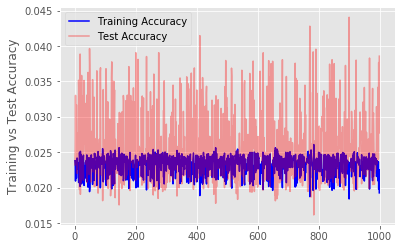

In [32]:
# Plot the scores

training_plot, = plt.plot(train_MSE, 'b')
test_plot, = plt.plot(test_MSE, 'r', alpha = 0.35)
plt.legend([training_plot, test_plot], ['Training Accuracy', 'Test Accuracy'])
plt.ylabel('Training vs Test Accuracy')
plt.show()

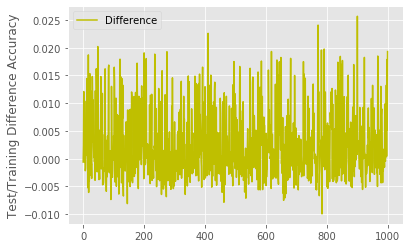

In [33]:
# Plot the difference in scores

diff_plot, = plt.plot(difference, 'y')
plt.legend([diff_plot], ['Difference'])
plt.ylabel('Test/Training Difference Accuracy')
plt.show()

In [34]:
# Look at summary of the differences in scores
difference_srs = pd.Series(difference)
difference_srs.describe()

count    1000.000000
mean        0.002550
std         0.006085
min        -0.009945
25%        -0.001905
50%         0.001048
75%         0.005693
max         0.025675
dtype: float64

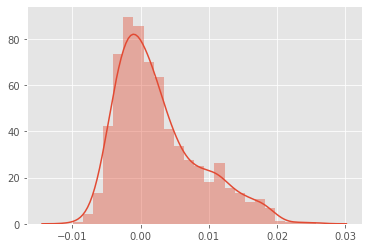

In [35]:
# Plot a histogram of the difference in scores
sns.distplot(difference_srs);

**Takeways:**

There is some variation in mse, depending on how we split the data.

* But it doesn't seem way off, IMHO
* Aka, our original train/test split is between the 25%ile and 50%ile.
* This variation, I suspect, is because a few of the sales prices are quite large (even after having eliminated outliers) and depending on how they're distributed across train/test it can make a difference.


### Look at whether adding normalization makes the model worse

The best scoring model does not normalize the predictor variables.  

However, adding normalization might give a better way of cross-comparing predictors (aka, all will be on the same scale of units) and might help with interpretability.  

So, I'm wondering what's the cost to my score of turning normalization on in the model.

In [36]:
# Split into training and test sets
# SKIP:  I'm using our existing split

# Instantiate model
lin_norm = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)

# Fit the model 
lin_norm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [37]:
# Predict and score off train

# Predict from x train
lin_norm_train_y_pred = lin_norm.predict(X_train)

# Format a bit
print('For the training set:')
print()

# Calc r-squared
lin_norm_train_r2 = r2_score(y_train, lin_norm_train_y_pred)
print('R-squared is {}'.format(lin_norm_train_r2))

# Calc MSE
lin_norm_train_mse = mean_squared_error(y_train, lin_norm_train_y_pred)
print('MSE is {}'.format(lin_norm_train_mse))

# Calc RMSE
lin_norm_train_rmse = np.sqrt(lin_norm_train_mse)
print('RMSE is {}'.format(lin_norm_train_rmse))

# Calc MAE
lin_norm_train_mae = mean_absolute_error(y_train, lin_norm_train_y_pred)
print('MAE is {}'.format(lin_norm_train_mae))

For the training set:

R-squared is 0.849440380000037
MSE is 0.023954163766872233
RMSE is 0.15477132734092652
MAE is 0.11223867285480427


In [38]:
# Predict and score off test

# Predict from x test
lin_norm_test_y_pred = lin_norm.predict(X_test)

# Format a bit
print('For the testing set:')
print()

# Calc r-squared
lin_norm_test_r2 = r2_score(y_test, lin_norm_test_y_pred)
print('R-squared is {}'.format(lin_norm_test_r2))

# Calc MSE
lin_norm_test_mse = mean_squared_error(y_test, lin_norm_test_y_pred)
print('MSE is {}'.format(lin_norm_test_mse))

# Calc RMSE
lin_norm_test_rmse = np.sqrt(lin_norm_test_mse)
print('RMSE is {}'.format(lin_norm_test_rmse))

# Calc MAE
lin_norm_test_mae = mean_absolute_error(y_test, lin_norm_test_y_pred)
print('MAE is {}'.format(lin_norm_test_mae))

For the testing set:

R-squared is 0.8578400767455304
MSE is 0.02277710380175007
RMSE is 0.15092085277306802
MAE is 0.10948539788739521


**Takeaways:**

* In evaluating the training results of a normalized linear model,
* I see performance in line with the prior model

In [39]:
# Compare test results of non-normalized v. normalized

results_dict_1 = {'set': ['non_normalized', 'normalized'],
        'root_mean_sqrd_error': [lin_test_rmse, lin_norm_test_rmse],
        'mean_sqrd_error': [lin_test_mse, lin_norm_test_mse],
        'r_squared': [lin_test_r2, lin_norm_test_r2],
        'mae' : [lin_test_mae, lin_norm_test_mae]
        }
results_df_1 = pd.DataFrame(results_dict_1)

# Sort dataframe
results_df_1.sort_values(by='root_mean_sqrd_error', ascending=False, inplace=True)
results_df_1

,set,root_mean_sqrd_error,mean_sqrd_error,r_squared,mae
0,non_normalized,0.150921,0.022777,0.85784,0.109485
1,normalized,0.150921,0.022777,0.85784,0.109485


**Takeaways:**

* When looking for overfitting, I don't see any issues
* When looking at model performance, I see similar performance
* Bottom line, I happy to use the normalized model.

### Save data on final model to use for comparisons in next notebook

In [40]:
# Create dataframe 
results_dict_2 = {'model': ['lin_norm_train', 'lin_norm_test'],
                  'y_set': ['y_train', 'y_test'],
                  'r2': [lin_norm_train_r2, lin_norm_test_r2],
                  'mse' : [lin_norm_train_mse, lin_norm_test_mse],
                  'rmse': [lin_norm_train_rmse, lin_norm_test_rmse],
                  'mae': [lin_norm_train_mae, lin_norm_test_mae],
                  'oob': ['None', 'None']
                 }
results_df_2 = pd.DataFrame(results_dict_2)

# Check
results_df_2

,model,y_set,r2,mse,rmse,mae,oob
0,lin_norm_train,y_train,0.84944,0.023954,0.154771,0.112239,None
1,lin_norm_test,y_test,0.85784,0.022777,0.150921,0.109485,None


In [41]:
# Write data
results_df_2.to_pickle("../sb_cap1_data/results_lr.pickle")

## Interpret the linear model

### Look at the coefficients

One use of this model is to help homeowners understand what are the factors that drive home prices.  For this, our regression coefficients are useful.

I will:  

* List the coefficients of our fully normalized predictors (aka, subtracting the mean and dividing by the l2-norm)
* By size

In [42]:
# Build a sorted table of coefficients
# With a bit of info on the type of feature

lin_normal_cols = X_train.columns.to_list()
lin_normal_ceof = [item for item in lin_norm.coef_.tolist()[0]]
lin_norm_coef_dicts = {'feature': lin_normal_cols,
                      'coefficient': lin_normal_ceof
                      }
lin_norm_coef_df = pd.DataFrame(lin_norm_coef_dicts)
lin_norm_coef_df.index.name = 'col_index'
lin_norm_coef_df['coefficient'] = lin_norm_coef_df['coefficient'].map(lambda x: '{:.4f}'.format(x))
lin_norm_coef_df['feature_type'] = 'noncat'
lin_norm_coef_df.loc[lin_norm_coef_df.feature.isin(garfin_list), 'feature_type'] = 'cat_garage_finish'
lin_norm_coef_df.loc[lin_norm_coef_df.feature.isin(neig_list), 'feature_type'] = 'cat_neigborhood'
lin_norm_coef_df['coefficient'] = lin_norm_coef_df['coefficient'].astype(float)
lin_norm_coef_df.sort_values(by='coefficient', ascending=False, inplace=True)
lin_norm_coef_df

,feature,coefficient,feature_type
col_index,,,
25,NoRidge,0.0971,cat_neigborhood
0,OverallQual,0.0927,noncat
34,Fin,0.0604,cat_garage_finish
2,TotRmsAbvGrd,0.0486,noncat
36,RFn,0.0474,cat_garage_finish
32,StoneBr,0.0460,cat_neigborhood
5,HeatingQC,0.0352,noncat
7,BsmtExposure,0.0226,noncat
26,NridgHt,0.0209,cat_neigborhood


In [43]:
lin_norm_coef_df.head()

,feature,coefficient,feature_type
col_index,,,
25,NoRidge,0.0971,cat_neigborhood
0,OverallQual,0.0927,noncat
34,Fin,0.0604,cat_garage_finish
2,TotRmsAbvGrd,0.0486,noncat
36,RFn,0.0474,cat_garage_finish


In [44]:
lin_norm_coef_df.tail()

,feature,coefficient,feature_type
col_index,,,
17,Edwards,-0.2557,cat_neigborhood
11,Blueste,-0.2705,cat_neigborhood
20,MeadowV,-0.3313,cat_neigborhood
12,BrDale,-0.3405,cat_neigborhood
19,IDOTRR,-0.3504,cat_neigborhood


**Takeaways:**

This tells us how much an increase in one of the predictors impacts the log of the sales price.  

* Plus, it's doing so in relative units.  
* That is, it's telling us that the same relative improvement in overall quality will increase the value more than same relative improvement in total rooms above ground.  
* Aka, it might be wiser to invest in overall quality rather than simply adding (low-quality) room.
* But note that challenge is that it's hard to compare improving quality and adding a room.  
* Really, the homeowner would like to measure \\$10000 dollars invested in one aspect of the home v. another.

This also tells us the direction of changes.  

* For example, moving from Veenker (the default location) to NoRidge really improves the value of the house.  
* But moving from Veenker to Timber reduces the value of the home.
* Of course, you can't really move homes.  So, that part doesn't make sense.
* But the numbers could still help with understanding the relative contribution of the neighborhoods.

One interesting example of positive and negative change is with garages finishes.

* The default is an unfinished garage.
* Adding a finish to the garage (aka, the highest quality) adds the most value
* Adding a rough finish to the garage (aka, medium quality) adds some value but not as much
* Having no garage (aka, eliminating the garage) destroys value.
* All of which make intuitive sense.

### Help home owners understand predicted value

One use of this model is to provide homeowners with predictions of the sales prices of individual homes.  

To do this, I will want to:

* Show an example prediction
* Include a prediction interval

#### To start:  get predicted price

In [45]:
# Pull a random example from our test set of 363 observatons using numpy function
seed(32)
test_rand = randint(0, 363, 1)[0]
print('I will be looking at the test observation indexed at {}'.format(test_rand))

I will be looking at the test observation indexed at 215


In [46]:
# Look at the details of the predictors
X_test.iloc[test_rand]

OverallQual       5.0
1stFlrSF        936.0
TotRmsAbvGrd      4.0
FireplaceQu       0.0
MasVnrArea        0.0
HeatingQC         5.0
BsmtFinSF1      248.0
BsmtExposure      0.0
WoodDeckSF        0.0
OpenPorchSF       0.0
Blmngtn           0.0
Blueste           0.0
BrDale            0.0
BrkSide           0.0
ClearCr           0.0
CollgCr           0.0
Crawfor           0.0
Edwards           0.0
Gilbert           0.0
IDOTRR            0.0
MeadowV           0.0
Mitchel           0.0
NAmes             1.0
NPkVill           0.0
NWAmes            0.0
NoRidge           0.0
NridgHt           0.0
OldTown           0.0
SWISU             0.0
Sawyer            0.0
SawyerW           0.0
Somerst           0.0
StoneBr           0.0
Timber            0.0
Fin               1.0
No                0.0
RFn               0.0
Name: 1095, dtype: float64

In [47]:
# Get our predicted price
this_lin_norm_test_y_pred = lin_norm_test_y_pred[test_rand][0]

# # Check
# this_lin_norm_test_y_pred

**Takeaway:**

* Here, our example homeowners have a home of 4 rooms, with 936 square feet on the first floor, a quality index of 5, located in North Ames, with a finished garage, etc.
* It's pretty average, maybe many rooms for a smaller home.

#### Approach 1:  Use the actual residual

In [48]:
# Get residuals
resid = lin_norm_test_y_pred - y_test

# # Check
# resid

In [49]:
# Get the actual sales price
this_actual = y_test.iloc[test_rand]

# Check
this_actual

SalePriceLog    11.767568
Name: 1095, dtype: float64

In [50]:
# Get quantiles
lower_ci = np.absolute(resid.SalePriceLog.quantile(0.025))
upper_ci = np.absolute(resid.SalePriceLog.quantile(0.975))

# # Check
# print(lower_ci)
# print(upper_ci)

# Calc interval
lower_a1 = this_lin_norm_test_y_pred - lower_ci
upper_a1 = this_lin_norm_test_y_pred + upper_ci

# # Check
# print(lower_a1)
# print(upper_a1)

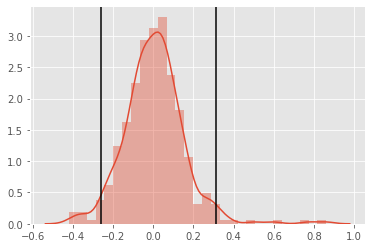

In [51]:
# Visualze the residual
g = sns.distplot(resid)
g = plt.axvline(-lower_ci, 0, color='black')
g = plt.axvline(upper_ci, 0, color='black')
# g = plt.ylabel('Regression coefficients from Lasso')
g = plt.show()


In [52]:
# Print values
print('The predicted price written as a natural log is {:.3f}'.format(this_lin_norm_test_y_pred))
print('With a 95% confidence interval between {:.3f} and {:.3f}'.format(lower_a1, upper_a1))
print()
print('The predicted price in dollars is {:}'.format(np.exp(this_lin_norm_test_y_pred)))
print('With a 95% confidence interval between {:.3f} and {:.3f}'.format(np.exp(lower_a1), np.exp(upper_a1)))

The predicted price written as a natural log is 11.725
With a 95% confidence interval between 11.467 and 12.039

The predicted price in dollars is 123634.9034895987
With a 95% confidence interval between 95482.580 and 169181.279


In [53]:
pred_ls = [lower_a1, this_lin_norm_test_y_pred, upper_a1, 
           np.exp(lower_a1), np.exp(this_lin_norm_test_y_pred), np.exp(upper_a1),
           this_actual[0], np.exp(this_actual[0])]

# Check
pred_ls 

[11.466699100776024,
 11.725088174833527,
 12.038726077356458,
 95482.57993531984,
 123634.9034895987,
 169181.2792591447,
 11.76756768334381,
 129000.00000000006]

#### Save data on final model to use for comparisons in next notebook

In [54]:
# Create dataframe 
pred_example_lin_dict = {'model': ['lin_norm'],
                  'y_test_iloc': [test_rand],
                  'pred_log_lower_ci': [lower_a1],
                  'pred_log': [this_lin_norm_test_y_pred],
                  'pred_log_upper_ci': [upper_a1],
                  'pred_dollar_lower': [np.exp(lower_a1)],
                  'pred_dollar': [np.exp(this_lin_norm_test_y_pred)],
                  'pred_dollar_upper': [np.exp(upper_a1)],
                  'actual_log': [this_actual[0]],
                  'actual_dollar': [np.exp(this_actual[0])]
                 }
pred_example_lin_df = pd.DataFrame(pred_example_lin_dict)

# Check
pred_example_lin_dict
pred_example_lin_df

,model,y_test_iloc,pred_log_lower_ci,pred_log,pred_log_upper_ci,pred_dollar_lower,pred_dollar,pred_dollar_upper,actual_log,actual_dollar
0,lin_norm,215,11.466699,11.725088,12.038726,95482.579935,123634.90349,169181.279259,11.767568,129000.0


In [55]:
# Write data
pred_example_lin_df.to_pickle("../sb_cap1_data/pred_example_lin_df")

#### Approach 2:  Assume a normal distribution

In [56]:
# Define a function to calc a prediction interval from linear regression

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)

    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = norm.ppf(ppf_lookup)
    interval = z_score * stdev

    #generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

# Sourced from stack overflow

In [57]:
# Get our predicted price
this_lin_norm_test_y_pred = lin_norm_test_y_pred[test_rand][0]
lower, pred, upper = get_prediction_interval(this_lin_norm_test_y_pred, y_test, lin_norm_test_y_pred)

In [58]:
# Print results
print('The predicted price written as a natural log is {:.3f}'.format(pred))
print('With a 95% confidence interval between {:.3f} and {:.3f}'.format(lower[0], upper[0]))
print()
print('The predicted price in dollars is {:}'.format((np.exp(pred))))
print('With a 95% confidence interval between {:.3f} and {:.3f}'.format(np.exp(lower[0]), np.exp(upper[0])))

The predicted price written as a natural log is 11.725
With a 95% confidence interval between 11.428 and 12.022

The predicted price in dollars is 123634.9034895987
With a 95% confidence interval between 91901.303 and 166326.145


**Takeaways:**

* We randomly selected a house that we didn't train the model on.
* In this case, it was a home with 936 square feet on first floor, 4 rooms, of mid-level quality (aka, index of 5), with a finished garage, located in North Ames, . . .

* Our predicted selling price is \\$123,600

* Plus, we're 95\% confident that the home should sell for 
* no less than \\$91,900, which might be considered as a worst case for the homeowner
* no more than \\$166,300, which might be considered as a best case for the homeowner

# Appendix:  Modeling using Ridge and Lasso

As noted above, there doesn't appear to be any overfitting with linear regression.  

So, we don't need to use ridge or lasso to fix that problem.

Still, I'd like to implement these models and compare the results to continue my learning.

## Modeling using Ridge

### Tune the model

In [59]:
# Instantiate a tuning model
ridg_tune = Ridge()

# Set up the grid
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 
              'normalize':[True,False],
              'fit_intercept':[True,False]}

# Instantiate the gridsearch
ridg_cv = GridSearchCV(ridg_tune, parameters, cv=5)

# Fit the gridsearch to the test data
ridg_cv.fit(X_train, y_train)

# Print results
print('The best parameters are {}'.format(ridg_cv.best_params_))
print('The best score is {}'.format(ridg_cv.best_score_))

The best parameters are {'alpha': 0.1, 'fit_intercept': True, 'normalize': True}
The best score is 0.8322081520384655


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Fit model

In [60]:
# Instantiate a best model
ridg = Ridge(alpha=0.1, fit_intercept=True, normalize=True)

# Fit best model
ridg.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

### Score off training

In [61]:
# Predict from x train and compare to y train
ridg_train_y_pred = ridg.predict(X_train)

# Format a bit
print('For the training set:')
print()

# Calc r-squared
ridg_train_r2 = r2_score(y_train, ridg_train_y_pred)
print('R-squared is {}'.format(ridg_train_r2))

# # Calc exlained variance
# ridg_train_ev = explained_variance_score(y_train, ridg_train_y_pred)
# print('Explained variance is {}'.format(ridg_train_ev))

# Calc MSE
ridg_train_mse = mean_squared_error(y_train, ridg_train_y_pred)
print('MSE is {}'.format(ridg_train_mse))

# Calc RMSE
ridg_train_rmse = np.sqrt(ridg_train_mse)
print('RMSE is {}'.format(ridg_train_rmse))

# # Calc MAPE
# ridg_train_mape = mape(y_train, ridg_train_y_pred)
# print('MAPE is {}'.format(ridg_train_mape))

# Calc MAE
ridg_train_mae = mean_absolute_error(y_train, ridg_train_y_pred)
print('MAE is {}'.format(ridg_train_mse))

For the training set:

R-squared is 0.847506284691361
MSE is 0.02426187997766483
RMSE is 0.15576225466288304
MAE is 0.02426187997766483


### Score off test

In [62]:
# Predict from x test and compare to y test
ridg_test_y_pred = ridg.predict(X_test)

# Format a bit
print('For the test set:')
print()

# Calc r-squared
ridg_test_r2 = r2_score(y_test, ridg_test_y_pred)
print('R-squared is {}'.format(ridg_test_r2))

# # Calc exlained variance
# ridg_test_ev = explained_variance_score(y_test, ridg_test_y_pred)
# print('Explained variance is {}'.format(ridg_test_ev))

# Calc MSE
ridg_test_mse = mean_squared_error(y_test, ridg_test_y_pred)
print('MSE is {}'.format(ridg_test_mse))

# Calc RMSE
ridg_test_rmse = np.sqrt(ridg_test_mse)
print('RMSE is {}'.format(ridg_test_rmse))

# # Calc MAPE
# ridg_test_mape = mape(y_test, ridg_test_y_pred)
# print('MAPE is {}'.format(ridg_test_mape))

# Calc MAE
ridg_test_mae = mean_absolute_error(y_test, ridg_test_y_pred)
print('MAE is {}'.format(ridg_test_mse))

For the test set:

R-squared is 0.8530460784091507
MSE is 0.023545206338902402
RMSE is 0.1534444731455076
MAE is 0.023545206338902402


## Model using Lasso

### Tune the model

In [63]:
# Instantiate a tuning model
lass_tune = Lasso()

# Set up the grid
parameters = {'alpha':[0.001, 0.005, 0.075, 0.01, 0.1, 0.5, 0.75, 1], 
              'normalize':[True, False],
              'fit_intercept':[True, False],
              'copy_X':[True, False]}

# Instantiate the gridsearch
lass_cv = GridSearchCV(lass_tune, parameters, cv=5)

# Fit the gridsearch to the test data
lass_cv.fit(X_train, y_train)

# Print results
print('The best parameters are {}'.format(lass_cv.best_params_))
print('The best score is {}'.format(lass_cv.best_score_))

The best parameters are {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'normalize': False}
The best score is 0.8236059171032614


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Build model

In [64]:
# Instantiate the model
lass = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, normalize=False)

# Fit the model 
lass.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Aside:  Visualize the coefficients

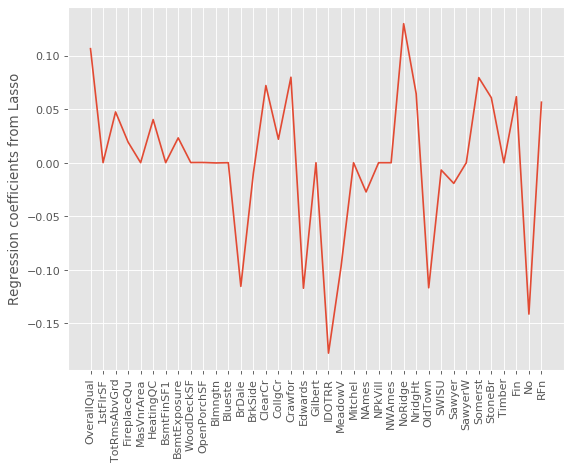

In [65]:
# Visualize the regression coefficients

lass_names = df_x.columns
lass_coef = lass.coef_
_ = figure(num=None, figsize=(8, 6), dpi=80)
_ = plt.plot(range(len(lass_names)), lass_coef)
_ = plt.xticks(range(len(lass_names)), lass_names, rotation = 90)
_ = plt.ylabel('Regression coefficients from Lasso')

In [66]:
# List the non-zero coefficients, in order of strength

lass_train_coeff = pd.DataFrame(list(zip(lass_names, lass_coef)), columns = ['Predictor', 'Coef'])
lass_train_coeff.sort_values(by='Coef', ascending=False, inplace=True)
lass_train_coeff_gtr_zero = lass_train_coeff[lass_train_coeff['Coef'] != 0].copy()
print('Of the {} predictors, {} have coefficients more than zero.  They are:'.format(len(lass_names), len(lass_train_coeff_gtr_zero)))
lass_train_coeff_gtr_zero

Of the 37 predictors, 30 have coefficients more than zero.  They are:


,Predictor,Coef
25,NoRidge,0.129796
0,OverallQual,0.106448
16,Crawfor,0.079814
31,Somerst,0.079429
14,ClearCr,0.072038
26,NridgHt,0.064413
34,Fin,0.061633
32,StoneBr,0.060667
36,RFn,0.056491
2,TotRmsAbvGrd,0.047412


### Score off training

In [67]:
# Predict from x train and compare to y train
lass_train_y_pred = lass.predict(X_train)

# Format a bit
print('For the training set:')
print()

# Calc r-squared
lass_train_r2 = r2_score(y_train, lass_train_y_pred)
print('R-squared is {}'.format(lass_train_r2))

# # Calc exlained variance
# lass_train_ev = explained_variance_score(y_train, lass_train_y_pred)
# print('Explained variance is {}'.format(lass_train_ev))

# Calc MSE
lass_train_mse = mean_squared_error(y_train, lass_train_y_pred)
print('MSE is {}'.format(lass_train_mse))

# Calc RMSE
lass_train_rmse = np.sqrt(lass_train_mse)
print('RMSE is {}'.format(lass_train_rmse))

# # Calc MAPE
# lass_test_mape = mape(y_train, lass_train_y_pred)
# print('MAPE is {}'.format(lass_test_mape))

# Calc MAE
lass_train_mae = mean_absolute_error(y_train, lass_train_y_pred)
print('MAE is {}'.format(lass_train_mse))

For the training set:

R-squared is 0.8420193970635695
MSE is 0.025134848472182655
RMSE is 0.1585397378330829
MAE is 0.025134848472182655


### Score off test

In [68]:
# Predict from x test and compare to y test
lass_test_y_pred = lass.predict(X_test)

# Format a bit
print('For the test set:')
print()

# Calc r-squared
lass_test_r2 = r2_score(y_test, lass_test_y_pred)
print('R-squared is {}'.format(lass_test_r2))

# # Calc exlained variance
# lass_test_ev = explained_variance_score(y_test, lass_test_y_pred)
# print('Explained variance is {}'.format(lass_test_ev))

# Calc MSE
lass_test_mse = mean_squared_error(y_test, lass_test_y_pred)
print('MSE is {}'.format(lass_test_mse))

# Calc RMSE
lass_test_rmse = np.sqrt(lass_test_mse)
print('RMSE is {}'.format(lass_test_rmse))

# # Calc MAPE
# lass_test_mape = mape(y_test, lass_test_y_pred)
# print('MAPE is {}'.format(lass_test_mape))

# Calc 
lass_test_mae = mean_absolute_error(y_test, lass_test_y_pred)
print('MAE is {}'.format(lass_test_mse))

For the test set:

R-squared is 0.8542598853782352
MSE is 0.023350728129452082
RMSE is 0.15280945039313532
MAE is 0.023350728129452082


## Compare results of linear, ridge and lasso

In [69]:
# Make single dataframe of all results
results_dict = {'technique': ['linear', 'ridge', 'lasso'],
        'r_squared': [lin_test_r2, ridg_test_r2, lass_test_r2],
        'mean_sqrd_error': [lin_test_mse, ridg_test_mse, lass_test_mse],
        'root_mean_sqrd_error': [lin_test_rmse, ridg_test_rmse, lass_test_rmse],
        'mae': [lin_test_mae, ridg_test_mae, lass_test_mae]}
results_df = pd.DataFrame(results_dict)

# Sort dataframe
results_df.sort_values(by='r_squared', ascending=False, inplace=True)
results_df

,technique,r_squared,mean_sqrd_error,root_mean_sqrd_error,mae
0,linear,0.857840,0.022777,0.150921,0.109485
2,lasso,0.854260,0.023351,0.152809,0.109819
1,ridge,0.853046,0.023545,0.153444,0.111241


**Takeaways:**

All of my regression models give, pretty much, the same results.  

* The linear model gives the best results, by a small margin.  
* Followed by lasso.
* Followed by ridge.

And this is pretty much what's expected, given that we don't have the symptoms of overfitting, which is what ridge and lasso help fix.